In [1]:
def get_geometry1(lat_list, lon_list, elev_list, return_center = False):
    nstat = len(lat_list)
    center_lat = 0.
    center_lon = 0.
    center_h = 0.
    geometry = np.empty((nstat, 3))

    for i in range(nstat):
        geometry[i, 0] = lon_list[i]
        geometry[i, 1] = lat_list[i]
        geometry[i, 2] = elev_list[i]

    center_lon = geometry[:, 0].mean()
    center_lat = geometry[:, 1].mean()
    center_h = geometry[:, 2].mean()
    for i in np.arange(nstat):
        x, y = util_geo_km(center_lon, center_lat, geometry[i, 0],
                               geometry[i, 1])
        geometry[i, 0] = x
        geometry[i, 1] = y
        geometry[i, 2] -= center_h

    if return_center:
        return np.c_[geometry.T,
                     np.array((center_lon, center_lat, center_h))].T
    else:
        return geometry
        
### DEFINITION OF ARRAY RESPONSE FROM CARDINAL--------------------------------------------------------------------------------------
def array_response(x, y, c_app=280, c_steps=50, freqmin=1, freqmax=2, freqsteps=50, px_0=0, py_0=0):
    '''---------------------------------------------------------------------------------------------------------
    Calculate array response on a square slowness grid for an arbitrary array of N elements

    Input:
        x (array): x-points in array
        y (array): y-points in array
        c_app (float/int): apparent velocity used to construct extent of slowness grid
        c_steps (int): define resolution of slowness grid
        freqmin (int): minimum frequency (Hz)
        freqmax (int): maximum frequency (Hz)
        freqsteps (int): frequency resolution
        px_0, py_0 (float/int): coordinates which define slowness correction

    Output:
        resp_norm[::-1] (array): response function map
        p_x (array): x-component slowness
        p_y (array): y-component slowness
        resp.max(): array gain
    ---------------------------------------------------------------------------------------------------------'''
    # Construct slowness square grid
    s_max = 1 / c_app 
    px = np.linspace(-s_max, s_max, c_steps)
    py = np.linspace(-s_max, s_max, c_steps)
    px, py = np.meshgrid(px, py)
    #-----------------------------------------------------------------------------------------------------------------#
    # Calculate each part
    i = 1j
    omega = 2 * np.pi * np.linspace(freqmin, freqmax, freqsteps)
    p_r_product = ((px[..., np.newaxis] + px_0) * np.array(x) + (py[..., np.newaxis] + py_0) * np.array(y))
    complex = -i * omega * p_r_product[..., np.newaxis]
    #-----------------------------------------------------------------------------------------------------------------#
    # Compile
    resp = np.sum(np.abs(np.sum(np.exp(complex), 2))**2, 2)
    resp_norm = resp / resp.max()
    
    return resp_norm[::-1], px, py, resp.max()

In [27]:
from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client
import numpy as np
import matplotlib.pyplot as plt

from obspy.imaging.cm import obspy_sequential
from obspy.signal.array_analysis import array_transff_wavenumber
import obspy
#from obspy.signal.array_analysis import get_geometry
from obspy.signal.util import util_geo_km

import pandas as pd
array = 'BIG' #2A, 3A, POM, 'BIG'
if array == 'BIG':
    df = pd.read_csv('/Users/cadequigley/Downloads/Research/network9c_array_mseed/all_stations_unalaska/us10002ngf_station_metadata.txt', sep = ' ' )
    df = pd.DataFrame(df[df['network']!= "9C"])
    df = pd.DataFrame(df[df['station']!= "MNAT"])
    filt_df = df[df['channel'].str[2] == 'Z']
    filt_df2 = filt_df[filt_df['channel'].str[0] == 'E']
    df = filt_df2.reset_index(drop=True)
        
else:
    df = pd.read_csv('/Users/cadequigley/Downloads/Research/network9c_array_mseed/all_stations_unalaska/us10002ngf_station_metadata.txt', sep = ' ' )
    df = pd.DataFrame(df[df['network']!= "9A"])
    df = pd.DataFrame(df[df['network']!= "AV"])
    df = pd.DataFrame(df[df['station'].str[0]== array[0]])
    df = df[df['channel'].str[2] == 'Z']
    if array == '3A': #drop stations not used in analysis
        df = pd.DataFrame(df[df['station']!= "3A10"])
        df = pd.DataFrame(df[df['station']!= "3A15"])
    elif array == 'POM': #drop stations not used in analysis
        df = pd.DataFrame(df[df['station']!= "POM06"])
        df = pd.DataFrame(df[df['station']!= "POM07"])
        df = pd.DataFrame(df[df['station']!= "POM13"])
    else:
        df = df
        
        
        
    
lat_list = df['latitude'].to_numpy()
lon_list = df['longitude'].to_numpy()
elev_list = df['elevation'].to_numpy()
output = get_geometry1(lat_list, lon_list, elev_list, return_center = False)

In [17]:
array_resp_max1 = array_resp_max #normalized to BIG array

8448.827273963554


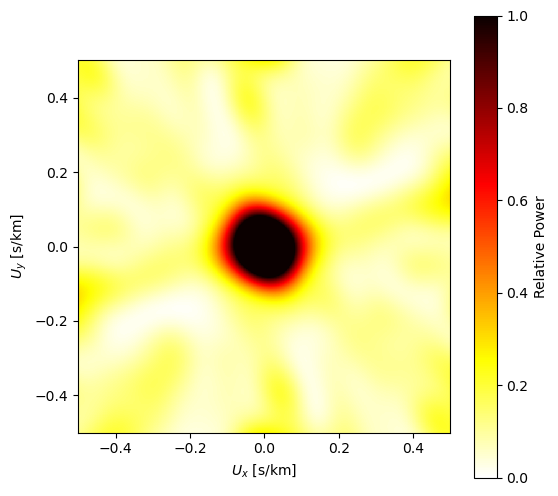

In [25]:
freq_min = 3
freq_max = 8

array_resp, p_x, p_y, array_resp_max = array_response(output[:,0], output[:,1], freqmin=freq_min, freqmax=freq_max, c_app=2, c_steps=600, freqsteps=50)
print(array_resp_max)
mean_tmp = np.mean(array_resp); std_tmp = np.std(array_resp)
RC = ((mean_tmp + std_tmp) / array_resp_max)

fig,ax = plt.subplots(figsize = (6,6))
#sc = ax.pcolormesh(p_x, p_y, array_resp, cmap='hot_r', vmin = 0, vmax = 1) #all normalized individually
sc = ax.pcolormesh(p_x, p_y, (array_resp*array_resp_max)/array_resp_max1, cmap='hot_r', vmin = 0, vmax = 1) #all normalized individually
#ax.yaxis.set_label_position("right")
#ax.yaxis.tick_right()
ax.set_xlabel(r'$U_{x}$ [s/km]'); ax.set_ylabel(r'$U_{y}$ [s/km]')
ax.set_aspect('equal', adjustable='box')
plt.colorbar(sc, label = 'Relative Power', ax = ax)
#mean_tmp = np.mean(array_resp); std_tmp = np.std(array_resp)
    #ax[i].set_title('Freq. Range: %.2f'%freq_min + ' to %.2f'%freq_max + ' Hz\nRC: '+ str(RC))
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5,0.5)
#ax.set_title('RC: '+ str(RC))
plt.savefig(array+'_response_function.png', transparent=True, dpi= 720)
plt.show()

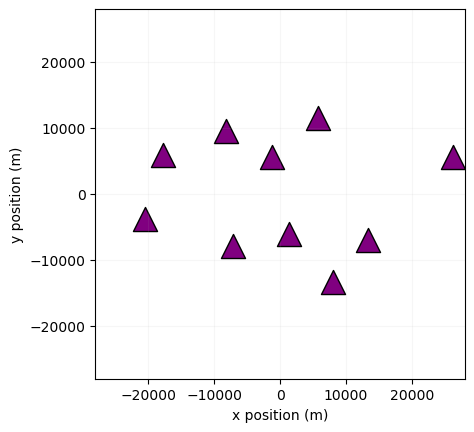

In [31]:
xpos = []
ypos = []
for i in range(len(output)):
    xpos.append((output[i][0])*1000)
    ypos.append((output[i][1])*1000)
fig,ax = plt.subplots()
ax.scatter(xpos, ypos, color = 'purple',marker = '^', linewidths = 1, s = 300,  edgecolors = 'black') #cornflowerblue
#ax.scatter(bhz_x, bhz_y, color = 'gray', marker = '^', linewidths = 1, s = 300, edgecolors= 'black', alpha= 0.5)
#ax.scatter(0,0, color = 'red', s= 100)
ax.set_xlabel("x position (m)")
ax.set_ylabel("y position (m)")
ax.grid(alpha = 0.1)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-28000,28000)
ax.set_ylim(-28000, 28000)
plt.savefig('BIG_geometry.png', transparent=True, dpi= 720)
plt.show()

In [30]:
df

,network,station,location,channel,latitude,longitude,elevation,gain,samplerate,units
0,AV,MREP,--,EHZ,53.8096,-166.7476,785.0,7.209800e+08,100.0,DU/M/S
1,AV,MGOD,--,EHZ,53.7938,-166.8780,650.0,1.948200e+08,100.0,DU/M/S
2,AV,MCIR,--,EHZ,53.9505,-166.8942,800.0,1.817500e+08,100.0,DU/M/S
3,AV,MSW,--,EHZ,53.9148,-166.7880,423.0,3.502600e+08,100.0,DU/M/S
4,AV,MTBL,--,EHZ,53.9680,-166.6813,810.0,3.563800e+08,100.0,DU/M/S
5,9A,MVP1,00,EHZ,53.9180,-167.0383,280.2,1.749920e+09,100.0,DU/M/S
6,9A,MVP2,00,EHZ,53.8310,-167.0792,475.7,1.749920e+09,100.0,DU/M/S
7,9A,MVP3,00,EHZ,53.7449,-166.6461,369.4,1.749920e+09,100.0,DU/M/S
8,9A,MVP4,00,EHZ,53.8018,-166.5658,255.1,1.749920e+09,100.0,DU/M/S
9,9A,MVP5,00,EHZ,53.9156,-166.3708,163.4,1.749920e+09,100.0,DU/M/S
